<a href="https://colab.research.google.com/github/agitonga-AI4Sustain/Energy-Forecasting-Model/blob/main/FINAL_Energy_Demand_Prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Energy forecasting model with LR 0.01, Neurons for the layers 64,64,21,16,1

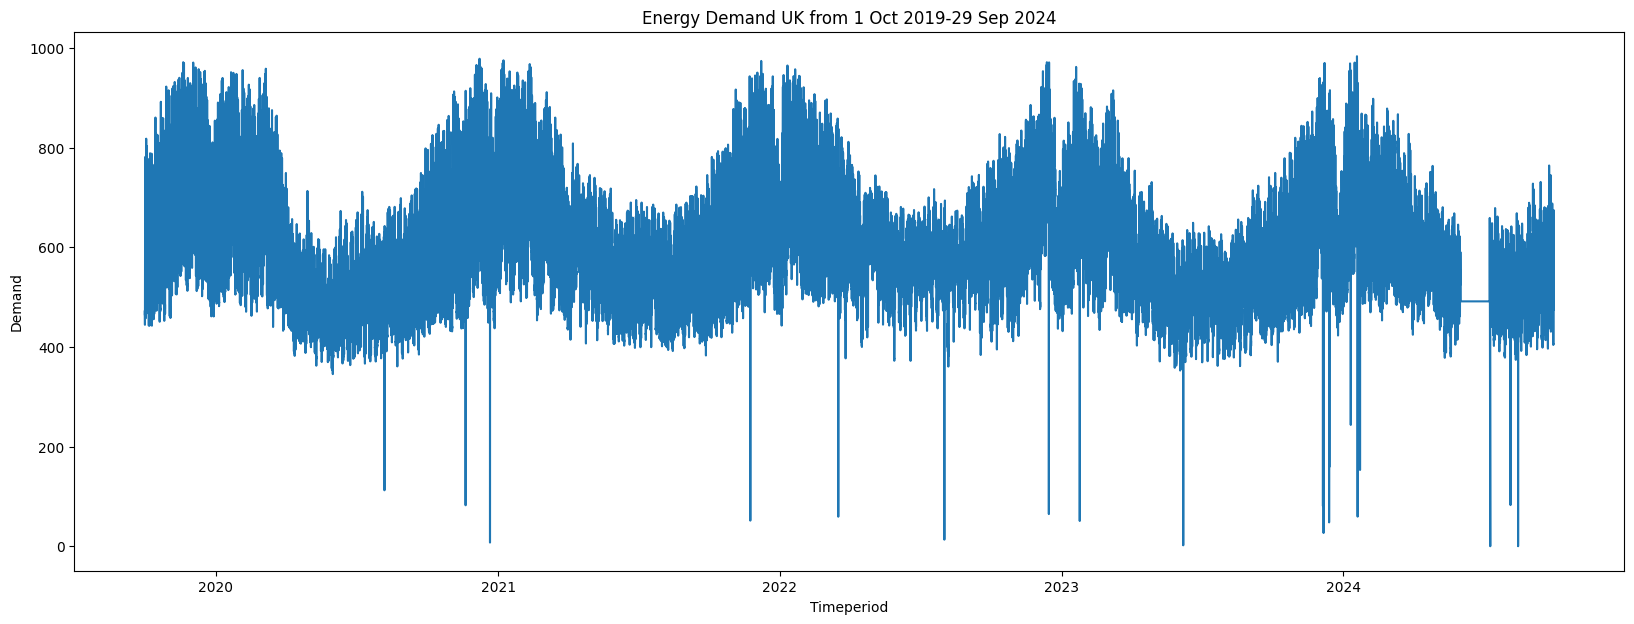

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 26760.3594 - mean_absolute_error: 98.4013 - val_loss: 3605.7625 - val_mean_absolute_error: 45.6288 - learning_rate: 0.0100
Epoch 2/200
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3674.6121 - mean_absolute_error: 46.5999 - val_loss: 3526.2817 - val_mean_absolute_error: 45.4709 - learning_rate: 0.0100
Epoch 3/200
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3518.9666 - mean_absolute_error: 45.9660 - val_loss: 4080.8735 - val_mean_absolute_error: 49.8377 - learning_rate: 0.0100
Epoch 4/200
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3342.7737 - mean_absolute_error: 44.7665 - val_loss: 3651.9775 - val_mean_absolute_error: 46.5263 - learning_rate: 0.0100
Epoch 5/200
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3093.5969 - mean_absolute_error: 43.0978 - val_loss: 3057.2812 - val_mean_absolute_error: 42.4055 - learning_rate: 0.0100
Epoch 6/200
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2967.9216 -

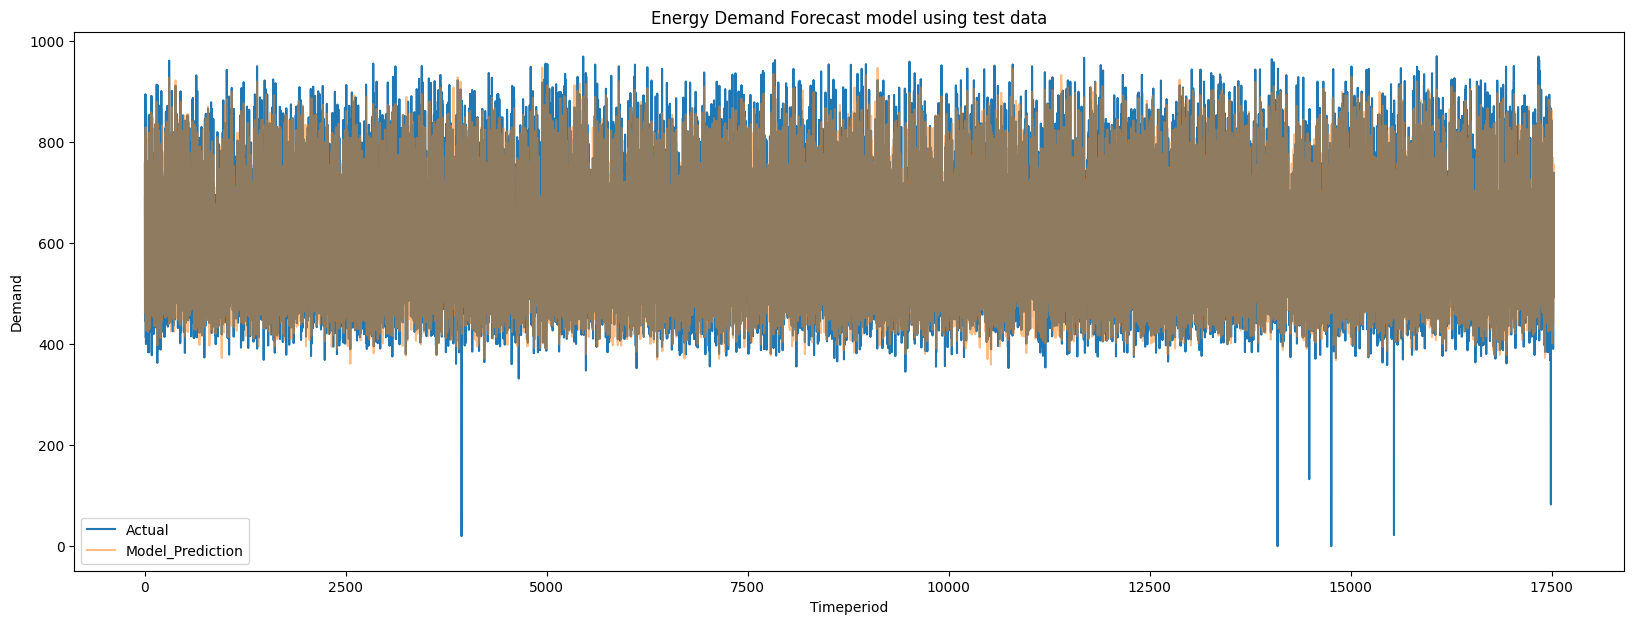

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
            Timeperiod  Predicted_Energy_Demand
0  2024-09-30 00:00:00               480.173706
1  2024-09-30 00:30:00               477.122711
2  2024-09-30 01:00:00               473.977112
3  2024-09-30 01:30:00               470.790741
4  2024-09-30 02:00:00               467.618164
5  2024-09-30 02:30:00               465.329803
6  2024-09-30 03:00:00               465.940643
7  2024-09-30 03:30:00               467.557465
8  2024-09-30 04:00:00               468.840881
9  2024-09-30 04:30:00               470.648560
10 2024-09-30 05:00:00               475.203033
11 2024-09-30 05:30:00               501.139526
12 2024-09-30 06:00:00               532.099854
13 2024-09-30 06:30:00               562.879211
14 2024-09-30 07:00:00               594.117737
15 2024-09-30 07:30:00               621.961365
16 2024-09-30 08:00:00               640.817139
17 2024-09-30 08:30:00               640.443909
18 2024-09-30 09:00:00               635.587463
19

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load the data
hist_data= pd.read_csv('Historic data.csv')
headerlist= ['timeperiod','demand']
hist_data.columns = headerlist
hist_data['timeperiod']= pd.to_datetime(hist_data['timeperiod'])

#visualizing input data
plt.figure(figsize=(20,7))
plt.plot(hist_data['timeperiod'], hist_data['demand'])
plt.xlabel('Timeperiod')
plt.ylabel('Demand')
plt.title('Energy Demand UK from 1 Oct 2019-29 Sep 2024')
plt.show()

#datetime handling, using sin/cosine transformations since datetime features exhibit cyclical patterns
hist_data['hour_of_day'] = hist_data['timeperiod'].dt.hour
hist_data['minute_of_hour'] = hist_data['timeperiod'].dt.minute

#Column representing half-hour intervals
hist_data['half_hour_interval'] = hist_data['hour_of_day'] * 2 + (hist_data['minute_of_hour'] // 30)

# class for creating cyclic features
def create_cyclic_features(df, col_name, period):
    df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / period)
    df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / period)
    return df

# Extracting time components
hist_data['day_of_week'] = hist_data['timeperiod'].dt.dayofweek
hist_data['day_of_month'] = hist_data['timeperiod'].dt.day
hist_data['month_of_year'] = hist_data['timeperiod'].dt.month
hist_data['week_of_year'] = hist_data['timeperiod'].dt.isocalendar().week
hist_data['quarter_of_year'] = hist_data['timeperiod'].dt.quarter

hist_data = create_cyclic_features(hist_data, 'half_hour_interval',48)
hist_data = create_cyclic_features(hist_data, 'hour_of_day', 24)
hist_data = create_cyclic_features(hist_data, 'day_of_week', 7)
hist_data = create_cyclic_features(hist_data, 'day_of_month', 31)
hist_data = create_cyclic_features(hist_data, 'month_of_year', 12)
hist_data = create_cyclic_features(hist_data, 'week_of_year', 53)
hist_data = create_cyclic_features(hist_data, 'quarter_of_year', 4)

#defining features from timeperiod
features = ['half_hour_interval_sin', 'half_hour_interval_cos',
            'day_of_week_sin', 'day_of_week_cos',
            'day_of_month_sin', 'day_of_month_cos',
            'month_of_year_sin', 'month_of_year_cos',
            'week_of_year_sin', 'week_of_year_cos',
            'quarter_of_year_sin', 'quarter_of_year_cos']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    hist_data[features],
    hist_data['demand'],
    test_size=0.2,
    random_state=1
)

# Feature scaling
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Model definition
model= keras.Sequential(
    [
        layers.Dense(64, activation='relu', input_shape=(12,), name='layer1'),
        layers.Dense(64, activation='relu', name='layer2'),
        layers.Dense(32, activation='relu', name='layer3'),
        layers.Dense(16, activation='relu', name='layer4'),
        layers.Dense(1,  name='output')
    ]
)

model.compile(loss=keras.losses.MeanSquaredError(
    reduction="sum_over_batch_size",
    name="mean_squared_error",
    dtype=None
),
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=[keras.metrics.MeanAbsoluteError()])

Callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=10
                                     ),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras',
                                       monitor='val_loss',
                                       save_best_only=True
                                       ),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=10
                                         )
]

X_train= X_train.astype(np.float32)
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    callbacks=Callbacks,
                    validation_split=0.2
                    )

# To access validation loss and metrics
val_loss = history.history['val_loss']
val_mae = history.history['val_mean_absolute_error']

# Print  the validation metrics
print(f"Validation Loss: {val_loss[-1]}")
print(f"Validation MAE: {val_mae[-1]}")

#evaluate model
X_test = X_test.astype(np.float32)
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error on Test Data: {mae}")

#testing prediction
y_pred = model.predict(X_test)

'''Visualizing results and comparisons between actual and prediction'''
# Reset y_test indices
y_test_reset = y_test.reset_index(drop=True)
# Flatten y_pred as it is a 2D array from the scaler used earlier
y_pred_flat = y_pred.flatten()

# model comparison DataFrame
model_comparison = pd.DataFrame({
    'Actual': y_test_reset,
    'Model_Prediction': y_pred_flat
})
print(model_comparison.head())

#plotting the graph
#plot actual vs pred
plt.figure(figsize=(20,7))
plt.plot(model_comparison['Actual'],
         label='Actual'
         )
plt.plot(model_comparison['Model_Prediction'],
         label='Model_Prediction',
         alpha=0.5
         )
plt.xlabel('Timeperiod')
plt.ylabel('Demand')
plt.title('Energy Demand Forecast model using test data')
plt.legend()
plt.show()

#saving the model
model.save('demand_model.keras')

#loading saved model
prediction_model = keras.models.load_model('demand_model.keras')

#loading new data
forecast_data = pd.read_csv('forecast_data.csv')
forecast_data = pd.to_datetime(forecast_data['timeperiod'])


#adding class for cyclic features
def create_cyclic_features(df, col_name, period):
    df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / period)
    df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / period)
    return df

def preprocess_data(new_timeseries_data):
  new_data = pd.read_csv(new_timeseries_data)
  new_data['timeperiod'] = pd.to_datetime(new_data['timeperiod'])

  #Extracting time components
  new_data['hour_of_day'] = new_data['timeperiod'].dt.hour
  new_data['minute_of_hour'] = new_data['timeperiod'].dt.minute
  new_data['half_hour_interval'] = new_data['hour_of_day'] * 2 + (new_data['minute_of_hour']//30)

  new_data['day_of_week'] = new_data['timeperiod'].dt.dayofweek
  new_data['day_of_month'] = new_data['timeperiod'].dt.day
  new_data['month_of_year'] = new_data['timeperiod'].dt.month
  new_data['week_of_year'] = new_data['timeperiod'].dt.isocalendar().week
  new_data['quarter_of_year'] = new_data['timeperiod'].dt.quarter

  #creating cyclic features
  new_data = create_cyclic_features(new_data, 'half_hour_interval',48)
  new_data = create_cyclic_features(new_data, 'hour_of_day', 24)
  new_data = create_cyclic_features(new_data, 'day_of_week', 7)
  new_data = create_cyclic_features(new_data, 'day_of_month', 31)
  new_data = create_cyclic_features(new_data, 'month_of_year', 12)
  new_data = create_cyclic_features(new_data, 'week_of_year', 53)
  new_data = create_cyclic_features(new_data, 'quarter_of_year', 4)

  #defining features
  features = ['half_hour_interval_sin', 'half_hour_interval_cos',
            'day_of_week_sin', 'day_of_week_cos',
            'day_of_month_sin', 'day_of_month_cos',
            'month_of_year_sin', 'month_of_year_cos',
            'week_of_year_sin', 'week_of_year_cos',
            'quarter_of_year_sin', 'quarter_of_year_cos']
  new_data_features = new_data[features]

  #scaling data
  new_data_scaled = sc.transform(new_data_features)

  return new_data_scaled


forecast_data_scaled = preprocess_data('forecast_data.csv')
forecast_data_scaled = forecast_data_scaled.astype(np.float32)

demand_prediction = prediction_model.predict(forecast_data_scaled)
demand_prediction_flat = demand_prediction.flatten()

#creating Data Frame with results
prediction_results = pd.DataFrame({
    'Timeperiod': forecast_data,
    'Predicted_Energy_Demand': demand_prediction_flat
})

print(prediction_results)

In [ ]:
prediction_results.to_csv('prediction_results.csv')